In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import MySQLdb
from sqlalchemy import create_engine

import tools.feature_selection as fs
import tools.preprocessing as ps
import tools.evaluations as ev

## Data Import

### Import data from mysql

In [3]:
host = 'db1.ceobypqfxmry.us-east-2.rds.amazonaws.com'
port = '3306'
db = 'db'
user = 'admin'
password = 'msbd5001'
tb = 'train_features'
engine = create_engine(str(r"mysql+mysqldb://%s:" + '%s' + "@%s/%s") % (user, password, host, db))

In [4]:
df = pd.read_sql_table(tb, engine)
df.head()

,SK_ID_CURR,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,DAYS_EMPLOYED,AMT_GOODS_PRICE,DAYS_BIRTH,OCCUPATION_TYPE,ORGANIZATION_TYPE,AMT_CREDIT,...,bureau_AMT_CREDIT_MAX_OVERDUE_avg,CREDIT_TYPE_Microloan,bureau_AMT_CREDIT_MAX_OVERDUE_max,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_avg,bureau_AMT_CREDIT_SUM_min,POS_CASH_balance_CNT_INSTALMENT_avg,POS_CASH_balance_CNT_INSTALMENT_std,POS_CASH_balance_CNT_INSTALMENT_FUTURE_avg,POS_CASH_balance_CNT_INSTALMENT_FUTURE_std
0,100002,0.139376,0.262949,0.083037,-637,351000.0,-9461,Laborers,Business Entity Type 3,406597.5,...,1681.029,0.0,5043.645,450000.0,108131.945625,0.0,24.000000,0.000000,15.000000,5.477226
1,100003,NaN,0.622246,0.311267,-1188,1129500.0,-16765,Core staff,School,1293502.5,...,0.000,0.0,0.000,810000.0,254350.125000,22248.0,10.107143,2.756023,5.785714,3.773565
2,100004,0.729567,0.555912,NaN,-225,135000.0,-19046,Laborers,Government,135000.0,...,0.000,0.0,0.000,94537.8,94518.900000,94500.0,3.750000,0.433013,2.250000,1.479020
3,100006,NaN,0.650442,NaN,-3039,297000.0,-19005,Laborers,Business Entity Type 3,312682.5,...,NaN,NaN,NaN,NaN,NaN,NaN,12.000000,9.044335,8.650000,9.905933
4,100007,NaN,0.322738,NaN,-3038,513000.0,-19932,Core staff,Religion,513000.0,...,0.000,0.0,0.000,146250.0,146250.000000,146250.0,15.333333,4.847159,8.969697,6.264304


In [5]:
df.to_csv('./data/df_train_features.csv', index=False)

### Import data from csv

In [15]:
df = pd.read_csv('./data/df_train_features.csv')

## Data Processing

In [16]:
# Separating continuous and categorical variables (setting yout own rule)
cate_vars = []
cont_vars = []
for col in df.columns:
    if col not in ['SK_ID_CURR','SK_ID_CURR1','TARGET']:
        if df[col].dtype in ['float64','int64'] and df[col].nunique() > 3:
            cont_vars.append(col)
        else:
            cate_vars.append(col)

In [17]:
# Encoding categorical variables
df = ps.cate_enc(df, cate_vars)

## Modeling

In [9]:
df_fi = pd.read_excel('./features/df_fi.xlsx')
fi_median = df_fi['feature_importance'].median()
fi_features = df_fi[df_fi['feature_importance']>fi_median]['index'].values

In [18]:
# fill in missing value if use Random Forest
#df.fillna(0xdeadbeef, inplace=True)

# encoding TARGET
df['TARGET'] = df['TARGET'].astype('category')
features = [i for i in df if i not in ['TARGET','SK_ID_CURR']]
# split dataset
X_train, X_test, y_train, y_test = ps.split_data(df,fi_features,'TARGET')

### LightGBM

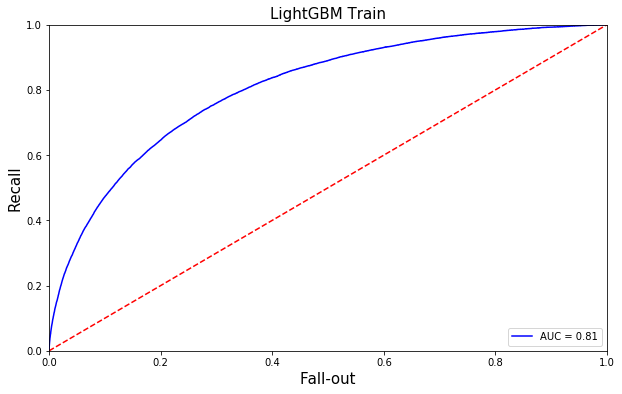

AUC:  0.8054658778114722
KS:  0.4610102864886276


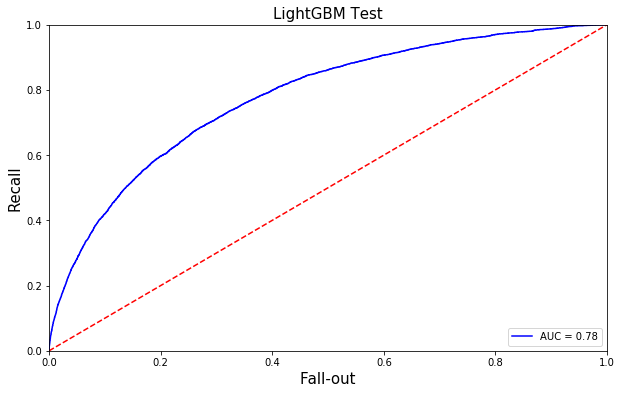

AUC:  0.7770723593762434
KS:  0.4139715532351547


In [13]:
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
# model training

#model = RandomForestClassifier(max_depth=9,n_estimators=100)
model = lgb.LGBMClassifier(bagging_fraction=0.7,
                                       bagging_freq=8,
                                       cat_smooth=1,
                                       feature_fraction=0.9,
                                       lambda_l1=0.5,
                                       lambda_l2=35,
                                       learning_rate=0.04,
                                       n_estimators=1250,
                                       max_depth=4,
                                       num_leaves=8,
                                       metric = 'auc')
model.fit(X_train, y_train)

# output probability
y_hat = model.predict_proba(X_train)[:,1]
y_pred = model.predict_proba(X_test)[:,1]

# evaluation
ev.plot_ROC(y_train, y_hat, 'LightGBM Train')
ev.plot_ROC(y_test, y_pred, 'LightGBM Test')

### Feature Importance

In [8]:
df_fi= pd.DataFrame(model.feature_importances_,index=features,columns=['feature_importance']).reset_index()
fi_mean = df_fi['feature_importance'].mean()
fi_median = df_fi['feature_importance'].median()
fi_features = df_fi[df_fi['feature_importance']>fi_median]['index'].values

In [13]:
df_fi.to_excel('./features/df_fi.xlsx', index=False)

### Tunning

In [15]:
from sklearn.model_selection import RandomizedSearchCV

parameters = {'n_estimators':[100,200,400,600,800,1000,1200],
              'max_depth': [4,5,6,8,10],
              'learning_rate': [0.005, 0.01, 0.02, 0.05, 0.1, 0.15],
              'feature_fraction': [0.6, 0.7, 0.8, 0.9, 0.95],
              'bagging_fraction': [0.6, 0.7, 0.8, 0.9, 0.95],
              'bagging_freq': [2, 4, 5, 6, 8],
              'lambda_l1': [0, 0.1, 0.4, 0.5, 0.6],
              'lambda_l2': [0, 10, 15, 35, 40],
              'cat_smooth': [1, 10, 15, 20, 35]
}
gbm = lgb.LGBMClassifier(boosting_type='gbdt',
                         objective = 'binary',
                         metric = 'auc',
                         verbose = 0,
                         learning_rate = 0.01,
                         num_leaves = 35,
                         feature_fraction=0.8,
                         bagging_fraction= 0.9,
                         bagging_freq= 8,
                         lambda_l1= 0.6,
                         lambda_l2= 0)


rsearch = RandomizedSearchCV(gbm, param_distributions =parameters, scoring='roc_auc', cv=3)
rsearch.fit(X_train, y_train)

print("Best score: %0.3f" % rsearch.best_score_)
print("Best parameters set:")
best_parameters = rsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.771
Best parameters set:
	bagging_fraction: 0.95
	bagging_freq: 5
	cat_smooth: 20
	feature_fraction: 0.9
	lambda_l1: 0.5
	lambda_l2: 35
	learning_rate: 0.1
	max_depth: 10
	n_estimators: 400


### Random Forest

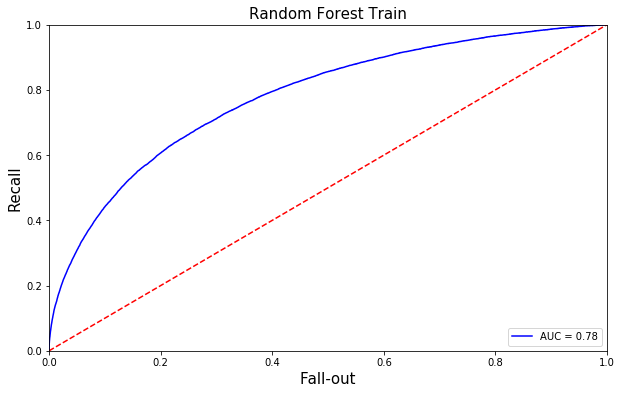

AUC:  0.7787977468734861
KS:  0.4149266080836987


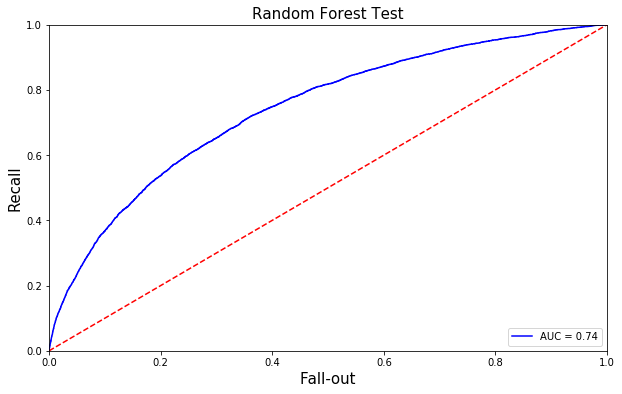

AUC:  0.7410569061276883
KS:  0.3578974972165963


In [20]:
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
# model training

rf_model = RandomForestClassifier(max_depth=8,n_estimators=80)
rf_model.fit(X_train, y_train)

# output probability
y_hat = rf_model.predict_proba(X_train)[:,1]
y_pred = rf_model.predict_proba(X_test)[:,1]

# evaluation
ev.plot_ROC(y_train, y_hat, 'Random Forest Train')
ev.plot_ROC(y_test, y_pred, 'Random Forest Test')

### Save Models

In [21]:
import joblib
joblib.dump(rf_model,'./model/rf.m')
joblib.dump(model,'./model/lgbm.m')

['./model/lgbm.m']